# CartPoleをQ-learningで学習する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display
%matplotlib inline

## 描画周りの関数

In [2]:
def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72, frames[0].shape[0]/72),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    anim.save('movie_cartpole.mp4')
    display(display_animation(anim, default_mode='loop'))

## CartPoleをランダムに動かしてみる

In [3]:
frames = []
env = gym.make('CartPole-v0')

# 最初に環境のresetが必須
observation = env.reset()

for step in range(200):
    # framesに各時刻の画像を追加していく
    frames.append(env.render(mode='rgb_array'))
    
    # action 0:左, 1:右
    action = np.random.choice(2) 
    
    observation, reward, done, info = env.step(action)

C:\Users\asano\Anaconda3\envs\test_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


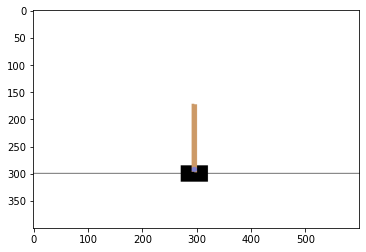

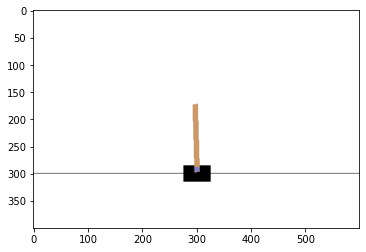

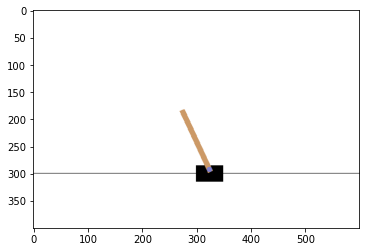

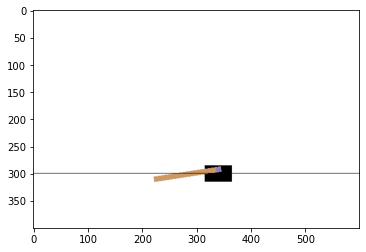

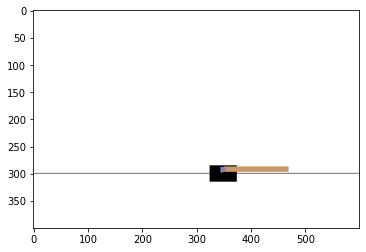

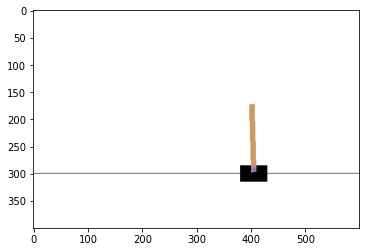

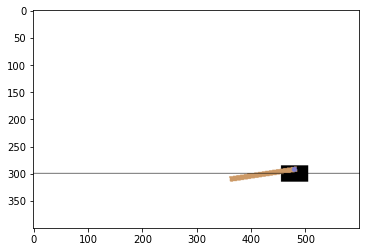

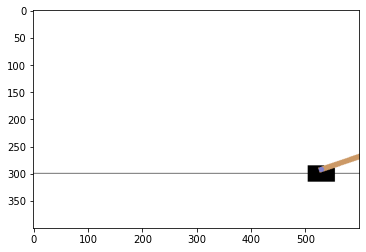

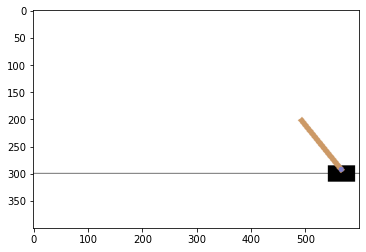

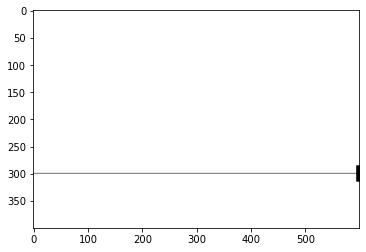

In [4]:
for i, frame in enumerate(frames):
    if i % 20 == 0:
        plt.figure()
        plt.imshow(frame)
        plt.show()

In [5]:
# NOTE なぜか動かない
#display_frames_as_gif(frames)

## 状態を離散化する

In [6]:
ENV = 'CartPole-v0'
NUM_DIZITIZED = 6
env = gym.make(ENV)
observation = env.reset()

In [7]:
# binsはどこで切って離散化するかの閾値
def bins(clip_min, clip_max, num):
    return np.linspace(clip_min, clip_max, num+1)[1:-1]
print(bins(-2.4, 2.4, NUM_DIZITIZED))

# np.digitize()で入力されたlistがbins区切りされたときに中央から何番目に位置するかのindexが返される.
def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIZITIZED)), # 0.5 rad = 29°
        np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIZITIZED))
    ]
    
    # NUM_DIZITIZEDの数だけの進数表記になる.
    # NUM_DIZITIZED = 6なら6進数表記
    # observation = (1,2,3,4)なら,
    # 1x6^0 + 2x6^1 + 3x6^2 + 4x6^3 = 状態985  として表現される
    return sum([x * (NUM_DIZITIZED ** i) for i, x in enumerate(digitized)])


[-1.6 -0.8  0.   0.8  1.6]


## Q-learningの実装

In [8]:
ENV = 'CartPole-v0'
NUM_DIZITIZED = 6
GAMMA = 0.99
ETA = 0.5 # 学習率
MAX_STEPS = 200  # steps per 1 episode
NUM_EPISODES = 1000

## Agentの実装
Agentは脳を持ち, 脳からactionの伝令をうけて行動する.

In [9]:
class Agent:
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        
    def update_Q_function(self, observation, action, reward, observation_next):
        '''
        Q関数の更新
        '''
        self.brain.update_Q_table(observation, action, reward, observation_next)
        
    def get_action(self, observation, step):
        action = self.brain.decide_action(observation, step)
        return action
    

## Brainの実装
脳の部分. Q-learningで学習したり, 

In [10]:
class Brain:
    '''
    Agentの脳. Q-learningを実行する.
    '''
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動数. 2.
        
        # Qテーブルの作成. [分割数^(4変数), actions(2)]の行列.
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**num_states, num_actions))
        
    def bins(self, clip_min, clip_max, num):
        '''
        観測した状態(連続値)を離散値にデジタル変換する閾値を求める.
        '''
        return np.linspace(clip_min, clip_max, num+1)[1:-1]
    
    def digitize_state(self, observation):
        '''
        観測したobservation状態を離散値へ変換する.
        '''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])
    
    def update_Q_table(self, observation, action, reward, observation_next):
        '''
        QテーブルをQ-learningにより更新.
        '''
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + ETA * (reward + GAMMA*max_Q_next - self.q_table[state, action])
    
    def decide_action(self, observation, episode):
        '''
        ε-greedyで徐々に最適行動のみを採用する.
        '''
        state = self.digitize_state(observation)
        epsilon = 0.5* (1/(episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)
        return action

## 環境
環境にはAgentが存在する.

In [13]:
class Environment:
    '''
    CartPoleを実行する環境のクラス
    '''
    def __init__(self):
        self.env = gym.make(ENV)
        num_states = self.env.observation_space.shape[0]  # 状態数4の取得.
        num_actions = self.env.action_space.n  # action数2の取得.
        self.agent = Agent(num_states, num_actions)
        
    def run(self):
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        is_episode_final = False  # 最終試行フラグ
        frames = []
        
        for episode in range(NUM_EPISODES):
            observation = self.env.reset()
            
            # goalがないので適当なstep数で打ち切る必要がある.
            for step in range(MAX_STEPS):
                if is_episode_final:
                    frames.append(self.env.render(mode='rgb_array'))
                
                # 行動を求める
                action = self.agent.get_action(observation, episode)
                
                # 行動a_tの実行により、s_{t+1}, a_{t+1}を求める
                # reward・infoは使わない. rewardはgym提供のものではなく, 自分で下で定義する
                observation_next, _, done, _ = self.env.step(action)
                
                # こけるか、200step耐えればdone = True
                if done:
                    if step < 195:
                        reward = -1
                        complete_episodes = 0
                    else:
                        reward = 1
                        complete_episodes += 1
                # 学習途中は報酬0
                else:
                    reward = 0
                
                self.agent.update_Q_function(observation, action, reward, observation_next)

                # update observation
                observation = observation_next
                
                # 終了時の処理
                if done:
                    print('{0} episode : finished after {1} times steps'.format(episode, step+1))
                    break
            if is_episode_final:
                display_frames_as_gif(frames)
                break
            if complete_episodes >= 10:
                print('successed 10 times sequentialy')
                is_episode_final = True

In [ ]:
cartpole_env = Environment()
cartpole_env.run()

0 episode : finished after 26 times steps
1 episode : finished after 28 times steps
2 episode : finished after 43 times steps
3 episode : finished after 45 times steps
4 episode : finished after 22 times steps
5 episode : finished after 32 times steps
6 episode : finished after 53 times steps
7 episode : finished after 42 times steps
8 episode : finished after 21 times steps
9 episode : finished after 70 times steps
10 episode : finished after 37 times steps
11 episode : finished after 26 times steps
12 episode : finished after 63 times steps
13 episode : finished after 30 times steps
14 episode : finished after 72 times steps
15 episode : finished after 71 times steps
16 episode : finished after 24 times steps
17 episode : finished after 99 times steps
18 episode : finished after 40 times steps
19 episode : finished after 51 times steps
20 episode : finished after 88 times steps
21 episode : finished after 23 times steps
22 episode : finished after 46 times steps
23 episode : finished